In [2]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from Signal_Analysis.features import signal
from python_speech_features import mfcc, logfbank
import scipy as sp
import numpy as np

def extract_long_audio_features(y, sr):
    # Load the audio file
#     y, sr = librosa.load(file_path)
    
    # Initialize the features list
    features = []
    
#     # Amplitude Envelope
#     amplitude_envelope = np.abs(librosa.amplitude_to_db(y))
#     features.extend(amplitude_envelope)
#     print(amplitude_envelope.shape)
    
    # Energy
    energy = np.sum(y ** 2)
    features.append(energy)
    
    # Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])
    features.append(zcr)
    
    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y)[0])
    features.append(rms)

    
#     # Short-time Energy
#     frame_length = 1024
#     hop_length = 512
#     ste = np.array([sum(abs(y[i:i+frame_length])**2) for i in range(0, len(y), hop_length)])
#     features.extend(ste)
    
#     # Autocorrelation
#     autocorr = np.correlate(y, y, mode='full')[len(y)-1:]
#     print(autocorr.shape)
#     features.extend(autocorr)
    
    # Peak Value
    peak_value = np.max(np.abs(y))
    features.append(peak_value)
    
    # Formants
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])
    pitch = np.array(pitch)
    pitch = pitch[pitch > 0]
    num_formants = min(5, len(pitch))
    formants = sorted(pitch)[:num_formants]
    features.extend(formants)
    
    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
    features.append(spectral_centroid)
    
    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0])
    features.append(spectral_bandwidth)

    # Spectral Flatness
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y)[0])
    features.append(spectral_flatness)
    
    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])
    features.append(spectral_rolloff)
    
    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    features.extend(spectral_contrast)
    
    
    # Harmonics-to-Noise Ratio (HNR)
    hnr = np.mean(librosa.effects.harmonic(y) / (librosa.effects.percussive(y) + 1e-10))
    features.append(hnr)
    
    # Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    features.extend(mfccs)
    
    # Fundamental Frequency
    f0 = np.mean(librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))
    features.append(f0)
    
    
    
    # Perform FFT
    fft_result = np.fft.rfft(y)
    fft_frequencies = np.fft.rfftfreq(len(y), d=1/sr)

    # Compute power spectrum
    power_spectrum = np.abs(fft_result)**2

    # Identify the cutoff index for 8 kHz
    cutoff_index = np.where(fft_frequencies >= 6000)[0][0]

    # Calculate power below and above 8 kHz
    power_below_8kHz = np.sum(power_spectrum[:cutoff_index])
    power_above_8kHz = np.sum(power_spectrum[cutoff_index:])
    features.append(power_below_8kHz)
    features.append(power_above_8kHz)
    
    
    # LH1000 Ratio
    # Identify the cutoff indices for 1 kHz and 8 kHz
    cutoff_index_1kHz = np.where(fft_frequencies >= 1000)[0][0]
    cutoff_index_8kHz = np.where(fft_frequencies >= 6000)[0][0]

    # Calculate power in the desired frequency bands
    power_0_to_1kHz = np.sum(power_spectrum[:cutoff_index_1kHz])
    power_1_to_8kHz = np.sum(power_spectrum[cutoff_index_1kHz:cutoff_index_8kHz])

    # Calculate the energy ratio (LH1000)
    LH1000 = power_0_to_1kHz / power_1_to_8kHz if power_1_to_8kHz != 0 else 0
    features.append(LH1000)
    
    
#     cutoff_index = np.where(fft_frequencies >= 16000)[0][0]
#     power_above_16kHz = np.sum(power_spectrum[cutoff_index:])
#     features.append(power_above_16kHz)
    
    
    
    ## HNR
    HNR = signal.get_HNR( y, sr )
    features.append(HNR)

    
    ##Filter banks
    fb_feat = logfbank(y, sr, nfilt=12)
    avg_fb = np.average(fb_feat, axis=0)
    print(fb_feat.shape, fb_feat[0].shape, avg_fb.shape)
    fb1 = fb_feat[0]
    print("Filter bank: ", fb_feat.shape)
    fb_beat_1 = fb_feat.flatten()
    for i in fb1:
        features.append(i)
        
        
    features.append(len(y)/float(sr))
    features.append(np.mean(abs(y)))                         # mean
    features.append(np.median(abs(y)))                       # median
    features.append(np.std(y, ddof=1))                       # std
    features.append(sp.stats.skew(y))                        # skewness
    features.append(sp.stats.kurtosis(y)) 

    return features




In [3]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import glob

# File paths
wav_files = glob.glob("ComParE2020_Mask/wav/*.wav")
label_file = 'Mask_labels_confidential.csv'

# Read the label file
labels_df = pd.read_csv(label_file)

# Function to segment audio files
def segment_audio(file_path, segment_length=1, overlap=0):
#     sr, y = wavfile.read(file_path)
    
    y, sr = librosa.load(file_path, sr=None)

    y, _ = librosa.effects.trim(y, top_db=20)

    segment_length_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments = []

    for start in range(0, len(y), segment_length_samples - overlap_samples):
        end = min(start + segment_length_samples, len(y))
        segments.append(y[start:end])

    return segments, sr

# Function to extract MFCC features
def extract_features(segments, sr):
    features = []
    for segment in segments:
        if len(segment) == 0:
            continue
        feat = extract_long_audio_features(segment, sr=sr)
        print(len(feat))
        if len(feat)!=64:
            continue
#         mfcc_mean = np.mean(mfcc, axis=1)
        features.append(feat)
    return np.array(features)

# Process each audio file and extract features
all_features = []
all_labels = []

for file_path in wav_files:
    segments, sr = segment_audio(file_path)
    file_name = os.path.basename(file_path)

    # Retrieve labels for this file
    file_labels = labels_df[labels_df['file_name'] == file_name]['label'].values

    features  = extract_features(segments, sr)
    

    all_features.extend(features)
    print(features.shape)
    labels = []
    for i in range(len(features)):
        labels.append(file_labels[0])
        
    all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Checking the shapes of the features and labels
all_features.shape, all_labels.shape


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(35, 12) (12,) (12,)
Filter bank:  (35, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(93, 12) (12,) (12,)
Filter bank:  (93, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/peakutils/peak.py:43: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


(89, 12) (12,) (12,)
Filter bank:  (89, 12)
64
(1, 64)
(76, 12) (12,) (12,)
Filter bank:  (76, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(64, 12) (12,) (12,)
Filter bank:  (64, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(93, 12) (12,) (12,)
Filter bank:  (93, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


(96, 12) (12,) (12,)
Filter bank:  (96, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(89, 12) (12,) (12,)
Filter bank:  (89, 12)
64
(1, 64)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w


(66, 12) (12,) (12,)
Filter bank:  (66, 12)
64
(1, 64)
(89, 12) (12,) (12,)
Filter bank:  (89, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(85, 12) (12,) (12,)
Filter bank:  (85, 12)
64
(1, 64)
(89, 12) (12,) (12,)
Filter bank:  (89, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(1, 64)
(86, 12) (12,) (12,)
Filter bank:  (86, 12)
64
(1, 64)
(96, 12) (12,) (12,)
Filter bank:  (96, 12)
64
(1, 64)
(95, 12) (12,) (12,)
Filter bank:  (95, 12)
64
(1, 64)
(98, 12) (12,) (12,)
Filter bank:  (98, 12)
64
(1, 64)
(96, 12) (12,) (12,)
Filter bank:  (96, 12)
64
(1, 64)


KeyboardInterrupt: 

In [4]:
# np.save('LongImproving_features.npy', all_features)
# np.save('LongImproving_labels.npy', all_labels)
# # all_features.shape, all_features_.shape
# # y = all_labels+y_train



all_features = np.load('LongImproving_features.npy')
all_labels = np.load('LongImproving_labels.npy')

In [5]:
all_features = np.array(all_features)

all_features.shape

# X = np.concatenate((all_features, X_train))


(26338, 64)

In [6]:
# X = np.reshape(X, [X.shape[0],49])
# y = np.array(labels_list)

# X_ = X[:,:-1]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# X_train = np.reshape(X_train, (X_train.shape[0], 42))
X_train

array([[ 2.75431946e+02,  5.01861572e-02,  9.75081101e-02, ...,
         1.31207898e-01, -1.13790464e+00,  4.09323831e+00],
       [ 1.19828247e+02,  1.87988281e-01,  7.44238794e-02, ...,
         8.65431428e-02, -5.00445306e-01,  1.00141737e+01],
       [ 2.29272995e+02,  1.98425293e-01,  9.98096839e-02, ...,
         1.19709596e-01, -1.74991691e+00,  5.79047540e+00],
       ...,
       [ 2.49542114e+02,  1.23596191e-01,  1.10809535e-01, ...,
         1.24889359e-01, -9.48761582e-01,  3.37893796e+00],
       [ 6.08079346e+02,  3.51562500e-02,  2.09316686e-01, ...,
         2.26022601e-01, -5.65072536e-01, -2.99324991e-01],
       [ 3.15927917e+02,  6.42641129e-02,  1.28954291e-01, ...,
         1.42826989e-01, -5.93028665e-01,  2.25674889e+00]])

In [18]:
# all_features.shape, all_features[2].shape, len(all_labels)
# all_features = np.reshape(all_features, (all_features.shape[0], 42))


X_test = X_test.astype(np.float)
X_train = X_train.astype(np.float)

X_test = np.nan_to_num(X_test)
X_train = np.nan_to_num(X_train)

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_98505/3569962390.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = X_test.astype(np.float)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_98505/3569962390.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = X_train.astype(np.float)


In [19]:
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)



In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)



Accuracy: 71.56%


In [21]:
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred))


Accuracy: 71.56%
              precision    recall  f1-score   support

       clear       0.71      0.69      0.70      2778
        mask       0.72      0.74      0.73      2970

    accuracy                           0.72      5748
   macro avg       0.72      0.71      0.71      5748
weighted avg       0.72      0.72      0.72      5748



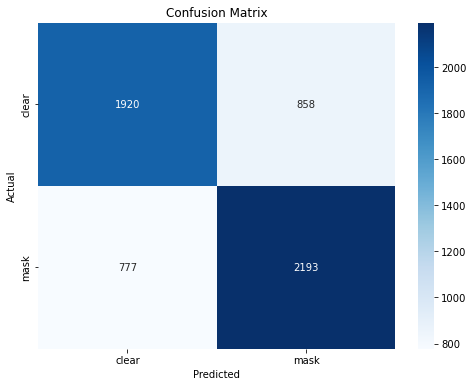

In [22]:
classes = np.unique(y_test)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

import matplotlib.pyplot as plt



precision: [0.71190211 0.71878073]
recall: [0.69114471 0.73838384]
fscore: [0.70136986 0.72845042]
support: [2778 2970]


In [24]:
from sklearn.metrics import confusion_matrix

def calculate_uar(y_true, y_pred):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # True Positives for each class
    tp_mask = cm[0, 0]  # Assuming 'mask' is the first class
    tp_clear = cm[1, 1]  # Assuming 'clear' is the second class

    # Total number of actual instances for each class
    n_mask = sum(cm[0, :])
    n_clear = sum(cm[1, :])

    # Calculate UAR
    uar = 0.5 * (tp_mask / n_mask + tp_clear / n_clear)
    return uar

# Example usage
# y_true = [actual labels]
# y_pred = [predicted labels]
uar = calculate_uar(y_test, y_pred)

uar


0.7147642734035822

In [25]:
import IPython

file = 'ComParE2020_Mask/wav/devel_00009.wav'
y, sr = librosa.load('ComParE2020_Mask/wav/devel_00001.wav', sr=None)

y, _ = librosa.effects.trim(y, top_db=20)

IPython.display.Audio(file)

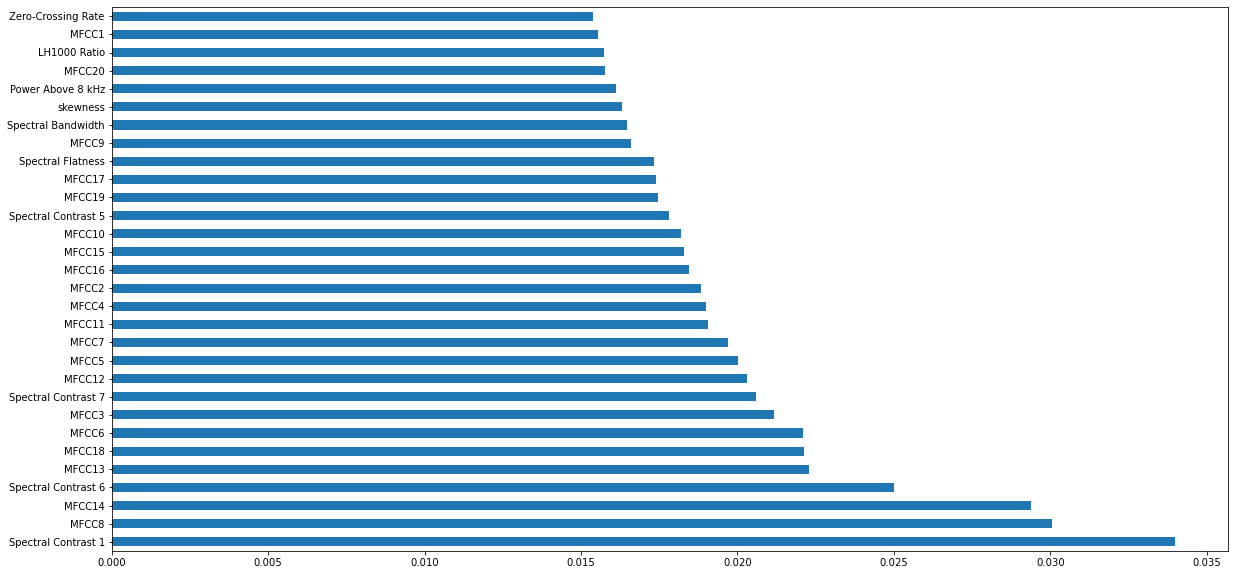

In [26]:
# Sort the features based on the aggregated importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer

# Updated Feature names
# feature_names = ['energy', 'ZCR', 'RMS', 'peak value', 'formant1', 'formant2', 'formant3', 'formant4', 'formant5', 'spectral centroid', 'spectral BW', 'spectral flatness', 'spectral rolloff'] + [f'spectral contrast{i}' for i in range(1, 8)] + ['HNR'] 
# Let's assume model, X, y are already defined
# model = RandomForestClassifier()
# model.fit(X, y)
feature_names = [
    "Energy",
    "Zero-Crossing Rate",
    "RMS Energy",
    "Peak Value",
    "Formant 1",
    "Formant 2",
    "Formant 3",
    "Formant 4",
    "Formant 5",
    "Spectral Centroid",
    "Spectral Bandwidth",
    "Spectral Flatness",
    "Spectral Rolloff",
    "Spectral Contrast 1",
    "Spectral Contrast 2",
    "Spectral Contrast 3",
    "Spectral Contrast 4",
    "Spectral Contrast 5",
    "Spectral Contrast 6",
    "Spectral Contrast 7",
    "Harmonics-to-Noise Ratio"] + [f'MFCC{i}' for i in range(1, 21)] + [ "Fundamental Frequency",
    "Power Below 8 kHz",
    "Power Above 8 kHz",
    "LH1000 Ratio",
    "HNR (second definition)"] + [f'FB{i}' for i in range(1, 13)] + ['value', 'mean', 'median', 'std', 'skewness', 'kurtosis']


X = all_features
y = all_labels

plt.figure(figsize=(20, 10))
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()


In [7]:
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pydub import AudioSegment

# File paths
mask_files = [
    'Abhay_mask.m4a',
    'Bhawana_mask.m4a',
    'S1_mask.m4a',
    'S4_mask.m4a',
    'S5_mask.m4a'
]
no_mask_files = [
    'Abhay_noMask.m4a',
    'Bhawana_noMask.m4a',
    'S1_noMask.m4a',
    'S4_noMask.m4a',
    'S5_noMask.m4a'
]

def segment_and_extract_features(file_name, frame_length=500, overlap=100):
    audio = AudioSegment.from_file(file_name, format="m4a")
    total_length = len(audio)
    step = frame_length - overlap
    
    features = []
    
    for start in range(0, total_length - frame_length + 1, step):
        end = start + frame_length
        segment = audio[start:end]
        
        samples = np.array(segment.get_array_of_samples())
        mfcc = librosa.feature.mfcc(samples, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        feature_vector = extract_mfcc_from_frame(samples)
        features.append(feature_vector)
    
    return features

# Extract segmented features using the pydub method
all_features_ = []
all_labels_ = []
for i in mask_files:
        segments, sr = segment_audio(i)
        features = extract_features(segments, sr)
        print('...',features)
        labels = []
        for i in range(len(features)):
            labels.append('mask')
        
        all_features_.extend(features)
        all_labels_.extend(labels)
        
for i in no_mask_files:
        segments, sr = segment_audio(i)
        features = extract_features(segments, sr)
        labels = []
        for i in range(len(features)):
            labels.append('clear')
        
        all_features_.extend(features)
        all_labels_.extend(labels)
        

    
# mask_segmented_features = [extract_features(f) for f in mask_files]
# no_mask_segmented_features = [extract_features(f) for f in no_mask_files]

# # Flatten the segmented feature lists and prepare the labels
# X_segmented = [item for sublist in mask_segmented_features for item in sublist] + [item for sublist in no_mask_segmented_features for item in sublist]
# y_segmented = [1 for _ in range(len([item for sublist in mask_segmented_features for item in sublist]))] + [0 for _ in range(len([item for sublist in no_mask_segmented_features for item in sublist]))]

# len(X_segmented), len(y_segmented)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(78, 12) (12,) (12,)
Filter bank:  (78, 12)
64
... [[5.62056923e+01 5.13318650e-02 2.61744689e-02 ... 3.42195295e-02
  5.95333278e-01 4.06673424e+00]
 [3.71532860e+01 5.31031832e-02 2.22244319e-02 ... 2.78216265e-02
  6.08070016e-01 2.52544462e+00]
 [2.09421387e+01 2.71879156e-02 1.72145739e-02 ... 2.08878573e-02
  6.87388182e-01 1.76403871e+00]
 ...
 [7.09508362e+02 4.74204205e-02 5.49105778e-02 ... 1.21580146e-01
  6.97087571e-02 2.60323250e+01]
 [1.30625458e+02 7.77302194e-02 2.18502842e-02 ... 5.21672368e-02
  7.54137218e-01 2.73039180e+01]
 [2.82776276e+02 4.07096354e-02 6.06936328e-02 ... 8.62469897e-02
  3.51480216e-01 1.10700342e+01]]


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(20, 12) (12,) (12,)
Filter bank:  (20, 12)
64
... [[ 6.02677059e+00  2.55152926e-02  9.39460751e-03 ...  1.12053715e-02
   4.53181844e-03  2.40291080e+00]
 [ 2.69637775e+00  3.80703541e-02  6.56177429e-03 ...  7.49504566e-03
  -3.99236828e-02  2.16257403e+00]
 [ 1.84909236e+00  4.15818235e-02  5.09617338e-03 ...  6.20673504e-03
   1.20575659e-01  4.35069568e+00]
 ...
 [ 2.05629978e+01  3.17694481e-02  1.71218608e-02 ...  2.06979383e-02
   1.39821451e-02  1.88891058e+00]
 [ 7.78677225e+00  2.11207613e-02  1.12238619e-02 ...  1.27368653e-02
   3.67425196e-02  5.38234977e-01]
 [ 6.21358633e-01  8.19091797e-02  6.59588631e-03 ...  7.94035010e-03
   2.15306766e-02  3.08613604e+00]]


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
59


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(61, 12) (12,) (12,)
Filter bank:  (61, 12)
64
... [[5.86927071e+01 2.82060339e-02 2.87330225e-02 ... 3.49683985e-02
  8.27219486e-01 3.69730558e+00]
 [2.79574337e+01 4.44232048e-02 1.99448969e-02 ... 2.41341610e-02
  1.32917988e+00 5.33646743e+00]
 [3.76771660e+01 3.74470163e-02 2.25174427e-02 ... 2.80170888e-02
  1.66557407e+00 8.11852199e+00]
 ...
 [3.63991814e+01 1.36355136e-02 2.43353620e-02 ... 2.75378246e-02
  1.28551090e+00 3.98136863e+00]
 [2.81894398e+01 1.68457031e-02 1.67168826e-02 ... 2.42341142e-02
  1.52856863e+00 7.95375263e+00]
 [1.15400066e+01 1.68332892e-02 1.67483017e-02 ... 1.96289122e-02
  1.47671831e+00 4.47046644e+00]]


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(14, 12) (12,) (12,)
Filter bank:  (14, 12)
64
... [[ 0.47724164  0.00859167  0.00304356 ...  0.00315309  0.07571052
  -0.23413802]
 [ 2.07709646  0.01745346  0.00570522 ...  0.00657824  0.07306968
   2.60363106]
 [ 2.37331676  0.01611328  0.00635905 ...  0.00703172 -0.17868114
   1.00751927]
 ...
 [ 2.5992074   0.01940658  0.00692203 ...  0.00735868  0.00303523
   0.52426755]
 [ 0.70935106  0.01171356  0.0037361  ...  0.00384419 -0.13159755
  -0.28859274]
 [ 0.15967691  0.00758464  0.00439774 ...  0.00469453  0.10866571
  -0.42063003]]


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(68, 12) (12,) (12,)
Filter bank:  (68, 12)
64
... [[ 3.73352736e-01  9.38642786e-03  2.71381694e-03 ...  2.78885174e-03
   6.99357912e-02 -1.19788734e-01]
 [ 3.08169335e-01  1.11317736e-02  2.44878605e-03 ...  2.53378320e-03
  -1.01716243e-01  4.17330452e-02]
 [ 1.50124848e+00  1.74586519e-02  4.90579149e-03 ...  5.59255295e-03
   7.31670856e-02  3.30306465e+00]
 ...
 [ 7.01232851e-01  3.11824717e-02  3.56502831e-03 ...  3.82220629e-03
  -2.37293765e-02  2.12860824e+00]
 [ 3.49942058e-01  1.34848737e-02  2.62617832e-03 ...  2.70009949e-03
   9.68609080e-02 -4.53183950e-01]
 [ 3.13587308e-01  1.37606534e-02  2.93992413e-03 ...  3.06665013e-03
  -2.00622156e-01 -2.08247759e-01]]


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(92, 12) (12,) (12,)
Filter bank:  (92, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(85, 12) (12,) (12,)
Filter bank:  (85, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(96, 12) (12,) (12,)
Filter bank:  (96, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64
(32, 12) (12,) (12,)
Filter bank:  (32, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
64


(67, 12) (12,) (12,)
Filter bank:  (67, 12)
64


In [53]:
all_features_ = np.array(all_features_)

In [14]:
all_labels, all_labels_

(array(['mask', 'mask', 'clear', ..., 'mask', 'clear', 'clear'],
       dtype='<U5'),
 ['mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'mask',
  'm

In [35]:
# np.save('OurData_LongImproving_features.npy', all_features_)
# np.save('OurData_LongImproving_labels.npy', all_labels_)

X = np.concatenate((all_features, all_features_))
y = all_labels.tolist()+all_labels_

NameError: name 'all_features' is not defined

In [36]:
X_train, X_test, y_train, y_test = train_test_split(all_features_, all_labels_, test_size=0.2, random_state=42)


y_pred =clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

NameError: name 'train_test_split' is not defined

In [39]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       clear       0.71      0.69      0.70       584
        mask       0.71      0.73      0.72       608

    accuracy                           0.71      1192
   macro avg       0.71      0.71      0.71      1192
weighted avg       0.71      0.71      0.71      1192



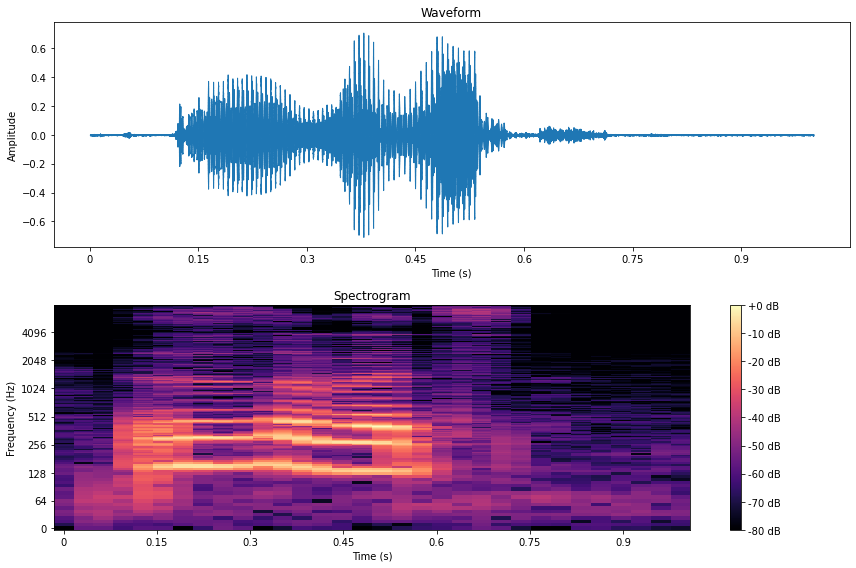

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
file_path = 'ComParE2020_Mask/wav/train_00005.wav'  # Replace with your audio file path
y, sr = librosa.load(file_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.subplot(2, 1, 2)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


In [1]:
# Load the audio file
file_path = 'ComParE2020_Mask/wav/train_00003.wav'  # Replace with your audio file path
y, sr = librosa.load(file_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.subplot(2, 1, 2)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


NameError: name 'librosa' is not defined

In [152]:
labels_df

,file_name,label,orig_file_name,corpus_file_name
0,train_00001.wav,clear,train_3625_00.wav,m_prob25_clear_read002_29_#2.7.wav
1,train_00002.wav,clear,train_1124_00.wav,f_prob11_clear_freespeech011_20_#3.6.wav
2,train_00003.wav,mask,train_2430_01.wav,f_prob17_mask_freespeech003_4_#3.8.wav
3,train_00004.wav,clear,train_0839_02.wav,f_prob07_clear_freespeech006_5_#4.2.wav
4,train_00005.wav,clear,train_3145_00.wav,m_prob15_clear_freespeech007_1_#4.9.wav
...,...,...,...,...
36549,test_11008.wav,mask,test_2618_03.wav,f_prob30_mask_freespeech011_18_#5.8.wav
36550,test_11009.wav,clear,test_0212_00.wav,f_prob30_clear_freespeech011_116_#4.3.wav
36551,test_11010.wav,clear,test_2631_00.wav,f_prob10_clear_read002_31_#1.1.wav
36552,test_11011.wav,clear,test_3007_07.wav,f_prob22_clear_freespeech007_3_#9.1.wav


In [8]:
import librosa
import numpy as np

def extract_dynamic_features(audio, sr, n_mfcc=13):
    # Extract MFCCs from the audio
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Compute first-order delta (rate of change)
    delta_mfccs = librosa.feature.delta(mfccs)

    # Compute second-order delta (acceleration)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    print(mfccs.shape, delta_mfccs.shape, delta2_mfccs.shape)

    # Concatenate MFCCs, delta, and delta-delta coefficients
    features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs), axis=0)

    return features

# Example usage:
audio, sr = librosa.load(file_path)
features = extract_dynamic_features(audio, sr)


(13, 44) (13, 44) (13, 44)


In [6]:
features.shape

(39, 44)

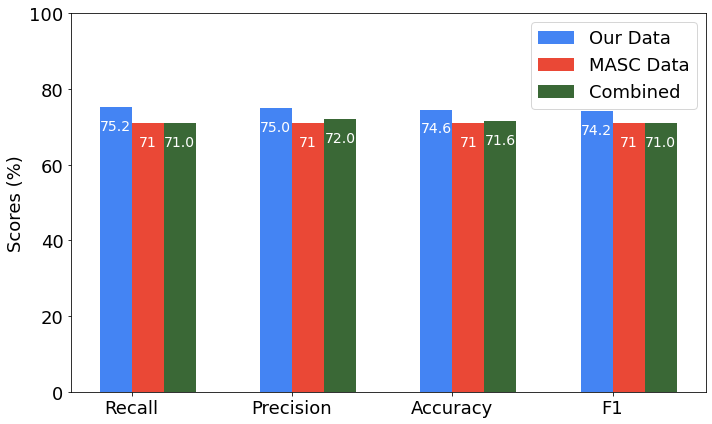

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data
our_data = [75.2, 75, 74.6, 74.2]
masc_data = [71, 71, 71, 71]
both = [71, 72, 71.6, 71]
# both = scores_percentage = {
#     'Accuracy': 71.56,   # Converted to percentage
#     'Precision': 72.00,  # Converted to percentage
#     'Recall': 71.00,     # Converted to percentage
#     'F1-Score': 71.00    # Converted to percentage
# }
labels = ['Recall', 'Precision', 'Accuracy', 'F1']

# X locations for the groups
x = np.arange(len(labels))

# Width of the bars
width = 0.2

# Create the plot
plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, our_data, width, label='Our Data', color='#4484f3')
rects2 = plt.bar(x + width/2 , masc_data, width, label='MASC Data', color='#ea4836')
rects3 = plt.bar(x + width/2+0.2 , both, width, label='Combined', color='#3a6836')


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Scores (%)', fontsize=18)
# plt.title('Comparison of Classification Metrics', fontsize=18)
plt.xticks(x, labels, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.ylim(0, 100)  # Set y-axis to range from 0 to 100%

# Function to add a label inside each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width() / 2, height - 5),  # Adjust position here
                     xytext=(0, 0),  # No offset
                     textcoords="offset points",
                     ha='center', va='center', fontsize=14, color='white')  # Increase font size here

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.savefig('MASCmask.png')
plt.show()


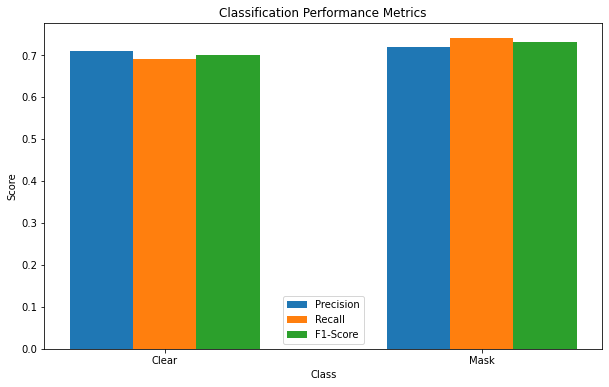

In [27]:
import matplotlib.pyplot as plt

# Classification results
classes = ['Clear', 'Mask']
precision = [0.71, 0.72]
recall = [0.69, 0.74]
f1_score = [0.70, 0.73]

# Creating the bar plot
x = range(len(classes))
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1-Score', align='center')

# Adding labels
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Performance Metrics')
plt.xticks([p + 0.2 for p in x], classes)
plt.legend()

# Show the plot
plt.show()



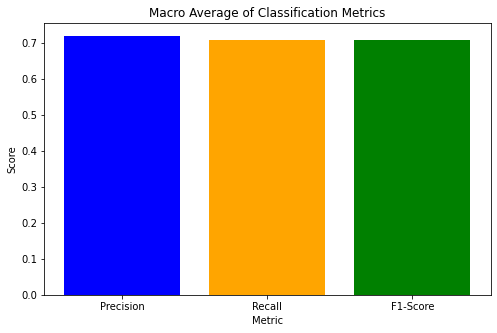

In [28]:
# import matplotlib.pyplot as plt

# # Macro average scores
# scores = {'Precision': 0.72, 'Recall': 0.71, 'F1-Score': 0.71}

# # Creating the bar plot
# plt.figure(figsize=(8, 5))
# plt.bar(scores.keys(), scores.values(), color=['blue', 'orange', 'green'])

# # Adding labels
# plt.xlabel('Metric')
# plt.ylabel('Score')
# plt.title('Macro Average of Classification Metrics')

# # Show the plot
# plt.show()


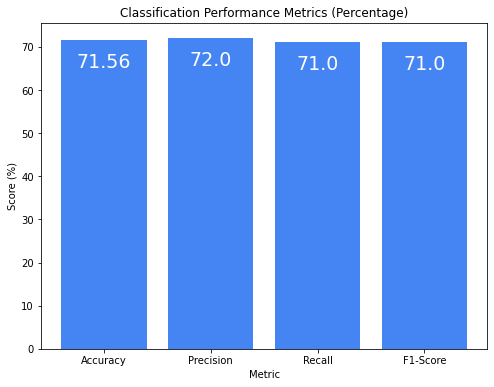

In [35]:
import matplotlib.pyplot as plt

# Adjusting the scores to be represented as percentages for plotting
scores_percentage = {
    'Accuracy': 71.56,   # Converted to percentage
    'Precision': 72.00,  # Converted to percentage
    'Recall': 71.00,     # Converted to percentage
    'F1-Score': 71.00    # Converted to percentage
}

# Creating the bar plot
plt.figure(figsize=(8, 6))
xyz = plt.bar(scores_percentage.keys(), scores_percentage.values(), color='#4484f3')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                     xy=(rect.get_x() + rect.get_width() / 2, height - 5),  # Adjust position here
                     xytext=(0, 0),  # No offset
                     textcoords="offset points",
                     ha='center', va='center', fontsize=19, color='white')  # Increase font size here

                     
                     
autolabel(xyz)

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Score (%)')
plt.title('Classification Performance Metrics (Percentage)')

# Show the plot
plt.show()


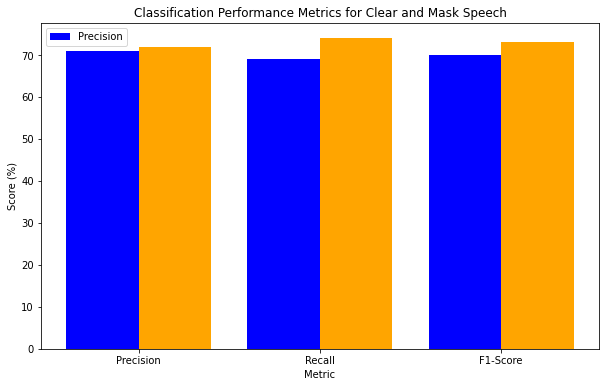

In [33]:
import matplotlib.pyplot as plt

# Classification performance metrics for 'Clear' and 'Mask' classes in percentage
performance_metrics = {
    'Precision': {'Clear': 71, 'Mask': 72},
    'Recall': {'Clear': 69, 'Mask': 74},
    'F1-Score': {'Clear': 70, 'Mask': 73}
}

# Colors for the bars
colors = ['blue', 'orange']

# Creating the bar plot
plt.figure(figsize=(10, 6))

# Adding bars for each metric
for i, metric in enumerate(performance_metrics):
    plt.bar(
        [i - 0.2, i + 0.2],
        [performance_metrics[metric]['Clear'], performance_metrics[metric]['Mask']],
        width=0.4,
        label=metric if i == 0 else "",
        color=colors
    )

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Score (%)')
plt.title('Classification Performance Metrics for Clear and Mask Speech')
plt.xticks(range(len(performance_metrics)), labels=performance_metrics.keys())
plt.legend()

# Show the plot
plt.show()
